# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '03'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 1956367)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 22:04:39 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qi   = xr.open_dataset(fname).q_snow.values
    ni   = xr.open_dataset(fname).n_snow.values
    temp = xr.open_dataset(fname).temp.values
    # mean cross sectional area, number weighted, multiply with ni for total area
    ai  = xr.open_dataset(fname).snow_area.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # ice density
    rhoi = 916.7
    # reff following Fu (1996) and Foot (1988), here Eq. (3.11) of Fu (1996)
    reff = np.where(ni>q_min,3./4.*qi/(ai*ni*rhoi),np.nan)   
    # transform everything in log space
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    qi = np.log(qi, where=qi>q_min, out=np.nan*qi)
    reff = np.log(reff, where=reff>p_min, out=np.nan*reff)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qi, ni, temp, reff ]))
    dataset = dataset.T
    dataset.columns = [ 'qi', 'ni', 'temp', 'reff' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


### Split in training, testing and validation with 70/15/15 rule

In [8]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [9]:
dataset_train.head()

qi        ni        temp      reff
2 -12.302848  6.967909  245.820007 -9.867637
3 -12.152892  7.106606  245.869995 -9.864644
4 -12.012647  7.238497  245.929993 -9.862882
6 -11.804709  7.454720  246.039993 -9.864574
7 -11.719950  7.543273  246.089996 -9.864982

In [10]:
dataset_train.describe()

qi            ni          temp          reff
count  1.181536e+06  1.181536e+06  1.181536e+06  1.181536e+06
mean  -9.080143e+00  1.045905e+01  2.416123e+02 -9.853494e+00
std    3.126540e+00  3.613814e+00  1.381445e+01  4.916265e-01
min   -2.763072e+01 -1.449861e+01  2.066400e+02 -3.251267e+01
25%   -1.012067e+01  9.749753e+00  2.315800e+02 -1.013017e+01
50%   -8.527143e+00  1.134730e+01  2.410300e+02 -9.960965e+00
75%   -7.128938e+00  1.259822e+01  2.500400e+02 -9.757017e+00
max   -4.005400e+00  1.608032e+01  2.854000e+02 -8.024898e-01

In [11]:
dataset_test.describe()

qi             ni           temp           reff
count  253258.000000  253258.000000  253258.000000  253258.000000
mean       -9.084182      10.466019     241.585236      -9.855559
std         3.121727       3.609798      13.765452       0.488056
min       -27.630121     -14.467842     207.000000     -20.845552
25%       -10.127225       9.762802     231.589996     -10.130386
50%        -8.537907      11.350312     241.029999      -9.962821
75%        -7.139473      12.597034     249.949997      -9.760466
max        -4.011346      16.069641     285.149994      -5.515173

In [12]:
dataset_val.describe()

qi             ni           temp           reff
count  252597.000000  252597.000000  252597.000000  252597.000000
mean       -9.070413      10.458203     241.661362      -9.852185
std         3.120020       3.608314      13.788973       0.493465
min       -27.630621     -14.467842     206.690002     -30.631771
25%       -10.113986       9.739674     231.679993     -10.129751
50%        -8.519345      11.348027     241.080002      -9.960078
75%        -7.122311      12.595239     250.070007      -9.755324
max        -4.009470      15.984015     285.700012      -5.432275

### Further reduce data to relevant parameter range

In [13]:
def reduce_data(dataset):
    idx = dataset[ dataset['reff'] > -7 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['qi'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['ni'] < -1 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 270 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [14]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
dataset_train.describe()

qi            ni          temp          reff
count  1.120739e+06  1.120739e+06  1.120739e+06  1.120739e+06
mean  -8.785300e+00  1.103321e+01  2.400131e+02 -9.895709e+00
std    2.335833e+00  2.487792e+00  1.225776e+01  3.925237e-01
min   -1.999784e+01 -9.981518e-01  2.066400e+02 -1.083113e+01
25%   -9.978653e+00  1.008899e+01  2.309800e+02 -1.013608e+01
50%   -8.499353e+00  1.147210e+01  2.402100e+02 -9.972148e+00
75%   -7.142832e+00  1.267113e+01  2.483900e+02 -9.781657e+00
max   -4.012285e+00  1.608032e+01  2.700000e+02 -7.545015e+00

In [16]:
dataset_test.describe()

qi             ni           temp           reff
count  240259.000000  240259.000000  240259.000000  240259.000000
mean       -8.790178      11.039124     239.990967      -9.897428
std         2.332965       2.482112      12.204945       0.391156
min       -19.997797      -0.998993     207.000000     -10.805626
25%        -9.983851      10.099054     230.990005     -10.136313
50%        -8.510118      11.473352     240.199997      -9.973527
75%        -7.152538      12.673886     248.309998      -9.784218
max        -4.012562      16.069641     270.000000      -7.595260

### Pairplot

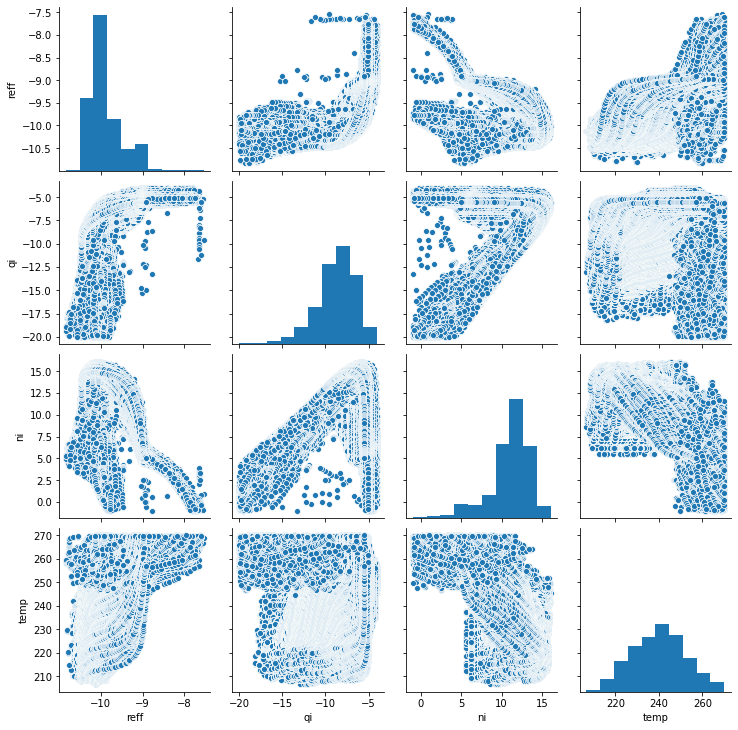

In [17]:
sns.pairplot(dataset_train[["reff","qi","ni","temp"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [18]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [19]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [20]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [21]:
#train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
#train_dataset2 = train_dataset2.drop(['temp','ssi'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)

In [22]:
#test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
#test_dataset2 = test_dataset2.drop(['temp','ssi'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)

In [23]:
#val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
#val_dataset2 = val_dataset2.drop(['temp','ssi'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)

In [24]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("reff")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean        std         min         25%         50%  \
qi    1120739.0   -8.785300   2.335833  -19.997845   -9.978653   -8.499353   
ni    1120739.0   11.033210   2.487792   -0.998152   10.088992   11.472103   
temp  1120739.0  240.013062  12.257758  206.639999  230.979996  240.210007   

             75%         max  
qi     -7.142832   -4.012285  
ni     12.671126   16.080320  
temp  248.389999  270.000000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [25]:
# pop does not work for multiple columns, use copy instead

labels = ['reff']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [26]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [27]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [28]:
train_labels.describe()

reff
count  1.120739e+06
mean  -9.895709e+00
std    3.925237e-01
min   -1.083113e+01
25%   -1.013608e+01
50%   -9.972148e+00
75%   -9.781657e+00
max   -7.545015e+00

In [29]:
train_dataset1.describe()

qi            ni          temp
count  1.120739e+06  1.120739e+06  1.120739e+06
mean  -8.785300e+00  1.103321e+01  2.400131e+02
std    2.335833e+00  2.487792e+00  1.225776e+01
min   -1.999784e+01 -9.981518e-01  2.066400e+02
25%   -9.978653e+00  1.008899e+01  2.309800e+02
50%   -8.499353e+00  1.147210e+01  2.402100e+02
75%   -7.142832e+00  1.267113e+01  2.483900e+02
max   -4.012285e+00  1.608032e+01  2.700000e+02

### Normalize the features

In [30]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_val_data1 = norm(val_dataset1,train_stats1)

In [31]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qi    1120739.0 -3.589385e-08  1.0 -4.800233 -0.510889  0.122417  0.703161   
ni    1120739.0  8.047931e-07  1.0 -4.836161 -0.379541  0.176419  0.658382   
temp  1120739.0 -5.037963e-06  1.0 -2.722607 -0.736926  0.016067  0.683399   

           max  
qi    2.043389  
ni    2.028751  
temp  2.446364

### Normalize the labels

In [32]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std        min        25%       50%       75%  \
reff  1120739.0 -9.895709  0.392524 -10.831134 -10.136075 -9.972148 -9.781657   

           max  
reff -7.545015

In [33]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [34]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H2(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H1(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H1":
        model = build_model_relu_Adam_H1(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H2":
        model = build_model_relu_Adam_H2(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [35]:

activ = "ReLU_Adam_H1"

model = build_model(3,6,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [37]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[0.56559205],
       [0.5590633 ],
       [0.5539887 ],
       [0.5492548 ],
       [0.5476984 ],
       [0.5477302 ],
       [0.5477991 ],
       [0.54771274],
       [0.549474  ],
       [0.5494602 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [38]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [39]:
nsize = 8
activ = "ReLU_Adam_H1"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0146,  mae:0.0675,  mse:0.0146,  val_loss:0.0102,  val_mae:0.0620,  val_mse:0.0102,  
..........

Text(0, 0.5, 'MAE')

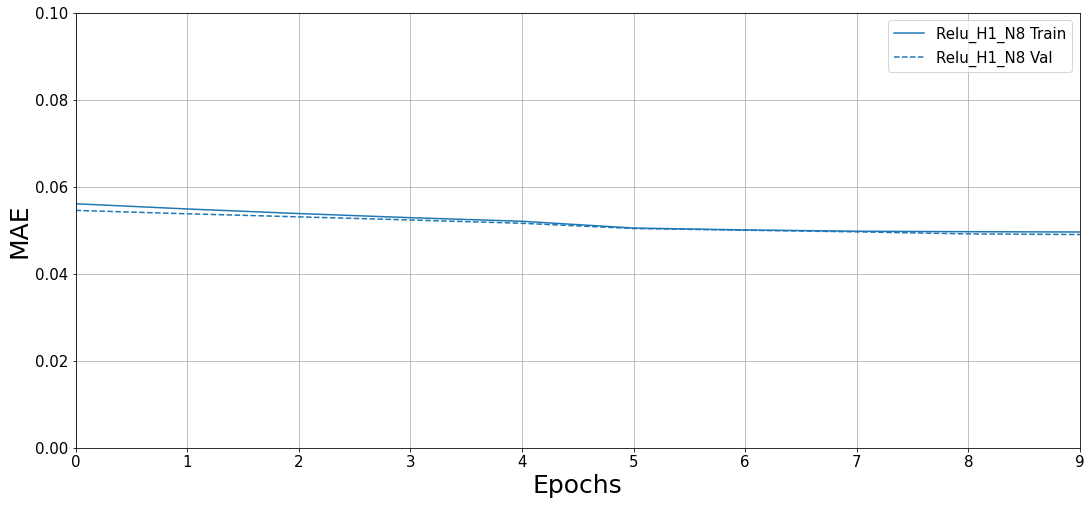

In [40]:
histories['ReLU_H1_n8'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0,0.1])
plt.ylabel('MAE')

In [41]:
nsize = 16
model2 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0120,  mae:0.0580,  mse:0.0120,  val_loss:0.0094,  val_mae:0.0536,  val_mse:0.0094,  
..............

Text(0, 0.5, 'MAE')

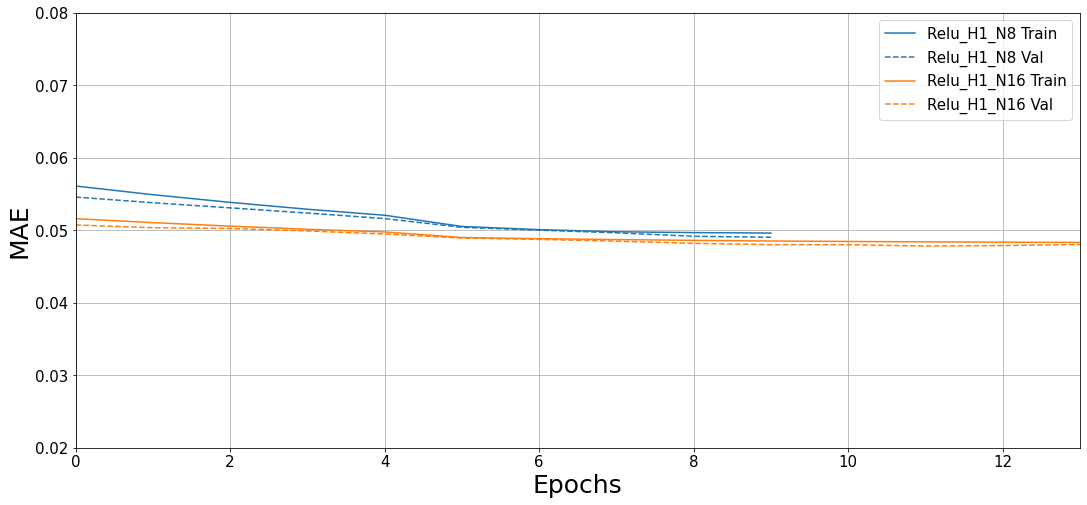

In [43]:
histories['ReLU_H1_n16'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.08])
plt.ylabel('MAE')

In [44]:
nsize = 8
activ = "ReLU_Adam_H2"
model3 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0205,  mae:0.0662,  mse:0.0205,  val_loss:0.0097,  val_mae:0.0588,  val_mse:0.0097,  
..........

Text(0, 0.5, 'MAE')

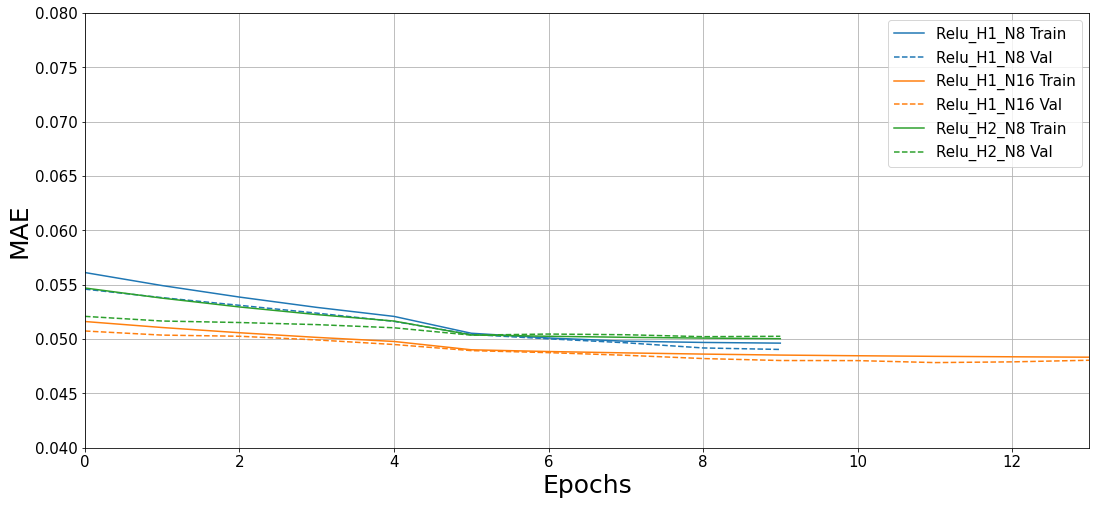

In [45]:
histories['ReLU_H2_n8'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.08])
plt.ylabel('MAE')

In [46]:
nsize = 16
activ = "ReLU_Adam_H2"
model4 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0114,  mae:0.0602,  mse:0.0114,  val_loss:0.0098,  val_mae:0.0580,  val_mse:0.0098,  
..........

Text(0, 0.5, 'MAE')

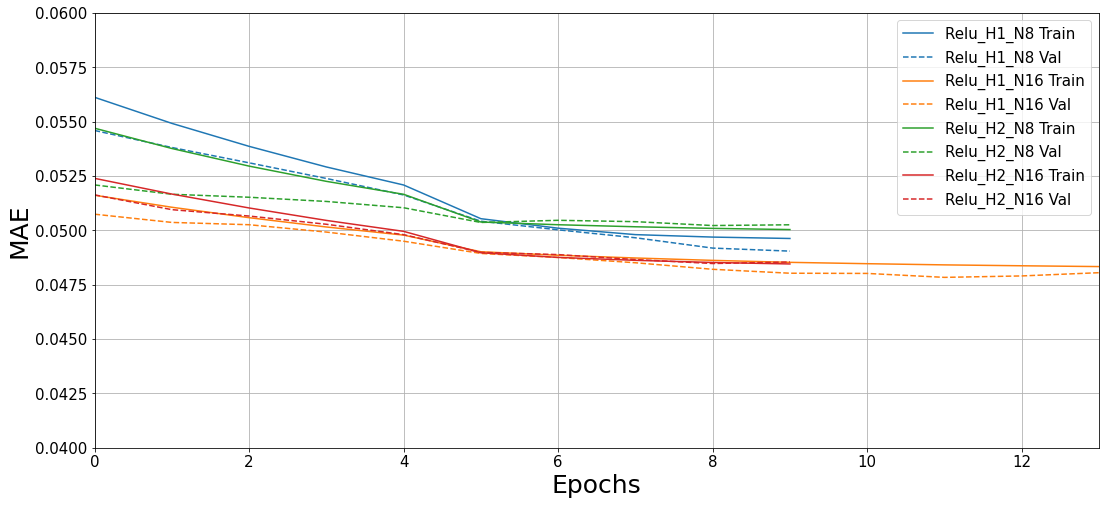

In [48]:
histories['ReLU_H2_n16'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.06])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

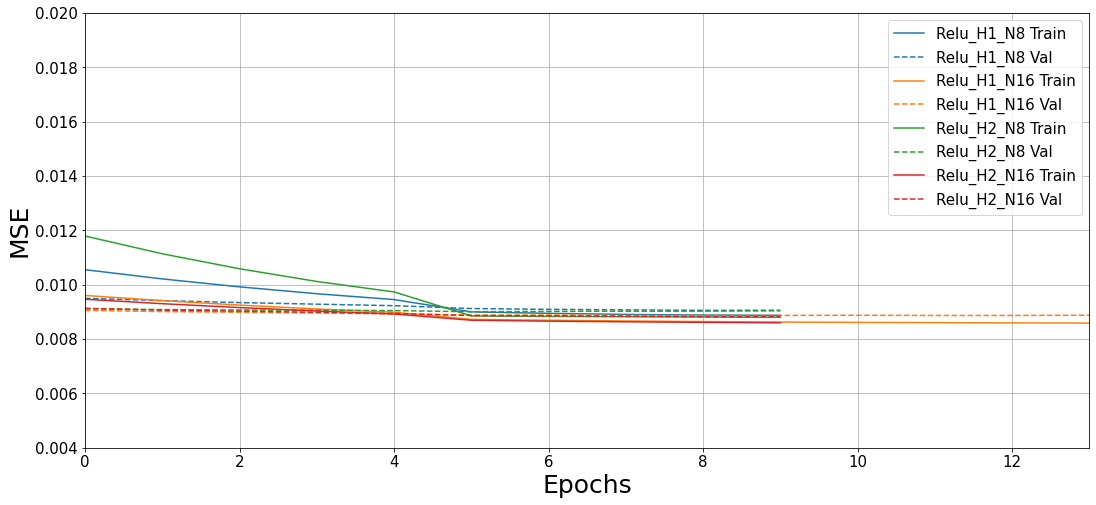

In [51]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.004, 0.02])
plt.ylabel('MSE')

In [52]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

240259/240259 - 5s - loss: 0.0087 - mae: 0.0492 - mse: 0.0087
Testing set for model 1, Mean Abs Error:    0.04923


In [53]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

240259/240259 - 5s - loss: 0.0084 - mae: 0.0458 - mse: 0.0084
Testing set for model 2, Mean Abs Error:              0.04580


In [54]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

240259/240259 - 6s - loss: 0.0085 - mae: 0.0486 - mse: 0.0085
Testing set for model 3, Mean Abs Error:              0.04861


In [55]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

240259/240259 - 6s - loss: 0.0084 - mae: 0.0468 - mse: 0.0084
Testing set for model 4, Mean Abs Error:              0.04679


In [56]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.049232133, 0.045804247, 0.048610408, 0.046791203]

In [57]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.008653163, 0.008403214, 0.008535989, 0.008365442]

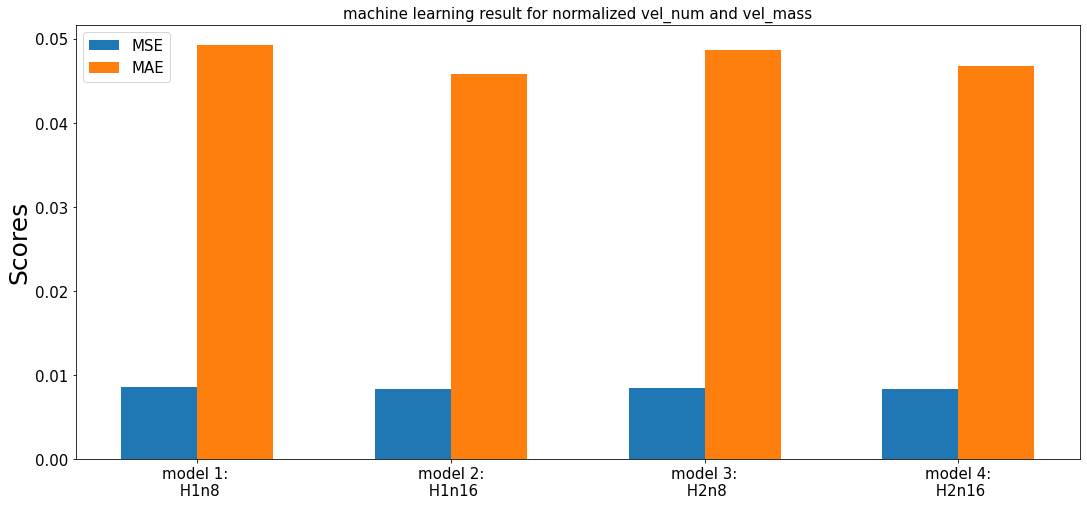

In [58]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1: \n H1n8',
 'model 2:\n H1n16',
 'model 3:\n H2n8',
 'model 4:\n H2n16' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [59]:
test_true_reff  = np.exp(test_labels.pop('reff'))

In [60]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [61]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["reff"])

In [62]:
p1.describe()

reff
count  240259.000000
mean        0.002250
std         0.992368
min        -2.184038
25%        -0.603053
50%        -0.185263
75%         0.290088
max         5.683446

In [63]:
train_labels_stats

count      mean       std        min        25%       50%       75%  \
reff  1120739.0 -9.895709  0.392524 -10.831134 -10.136075 -9.972148 -9.781657   

           max  
reff -7.545015

In [64]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [65]:
test_predict1.describe()

reff
count  240259.000000
mean        0.000055
std         0.000030
min         0.000021
25%         0.000040
50%         0.000047
75%         0.000056
max         0.000469

In [66]:
test_predict1_reff  = test_predict1['reff']

In [67]:

p2 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["reff"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_reff  = test_predict2['reff']

In [68]:

p3 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=["reff"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_reff = test_predict3['reff']

In [69]:

p4 = pd.DataFrame(data=model3.predict(normed_test_data1), columns=["reff"])

test_predict4 = np.exp(backtransform(p4,train_labels_stats))

test_predict4_reff  = test_predict4['reff']

### Maybe the ordering of the arrays is different? 

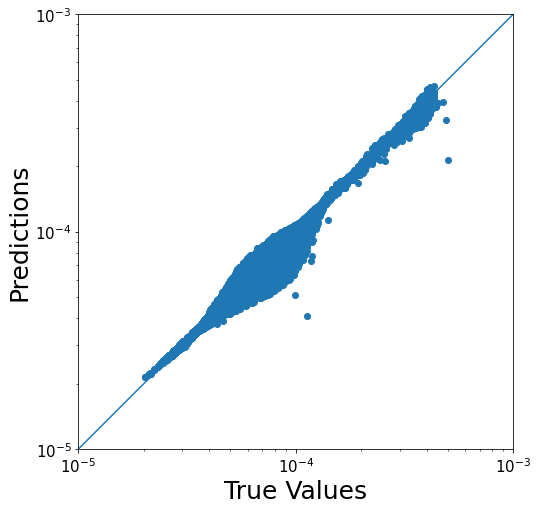

In [70]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-5, 1e-3

a = plt.axes(aspect='equal')
plt.scatter(test_true_reff, test_predict1_reff)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

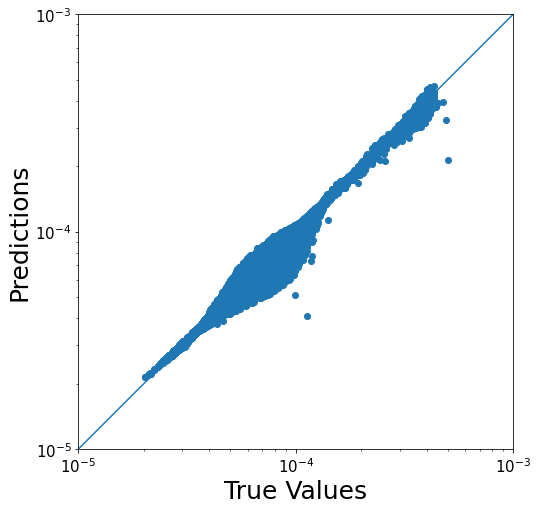

In [71]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_reff, test_predict2_reff)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

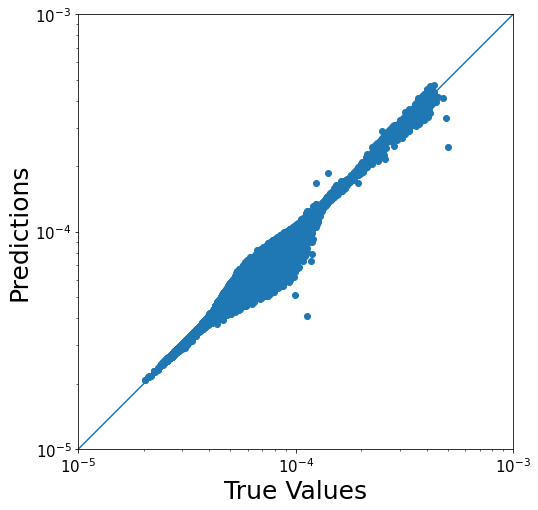

In [72]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_reff, test_predict3_reff)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

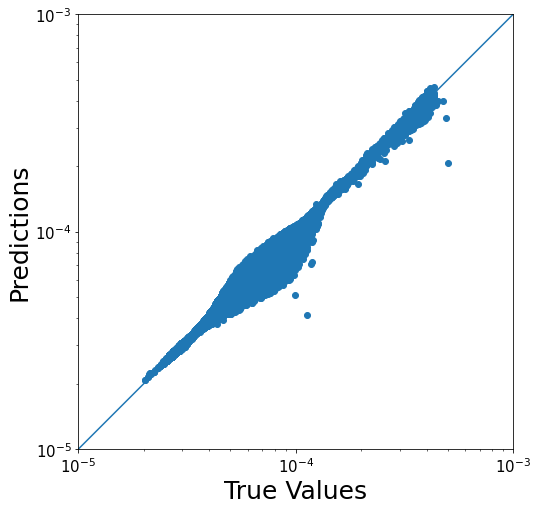

In [73]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_reff, test_predict4_reff)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [74]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [75]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [76]:
features = 'qi, ni, temp'
labels   = 'reff'
logtransform = np.array([True, True, False], dtype=bool)

save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_snow_model1_'+version+'.nc')
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_snow_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_snow_model3_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_snow_model4_'+version+'.nc')


Saving model to saved_model_v2/reff_snow_model1_03.nc
  Features:   qi, ni, temp
  Labels:     reff
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (3, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 1), Activation: linear
Saving model to saved_model_v2/reff_snow_model2_03.nc
  Features:   qi, ni, temp
  Labels:     reff
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (3, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/reff_snow_model3_03.nc
  Features:   qi, ni, temp
  Labels:     reff
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (3, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8

In [77]:
train_stats1

count        mean        std         min         25%         50%  \
qi    1120739.0   -8.785300   2.335833  -19.997845   -9.978653   -8.499353   
ni    1120739.0   11.033210   2.487792   -0.998152   10.088992   11.472103   
temp  1120739.0  240.013062  12.257758  206.639999  230.979996  240.210007   

             75%         max  
qi     -7.142832   -4.012285  
ni     12.671126   16.080320  
temp  248.389999  270.000000

In [78]:
activ = "ReLU_Adam_H1"
model = build_model(2,8,activ,1e-3)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [79]:
activ = "ReLU_Adam_H1"
model = build_model(2,16,activ,1e-3)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [80]:
activ = "ReLU_Adam_H2"
model = build_model(2,8,activ,1e-3)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [81]:
activ = "ReLU_Adam_H2"
model = build_model(2,16,activ,1e-3)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________
